# Prediction of Foraging States of *P. pacificus*

This notebook will guide you through the prediction pipeline for foraging behaviours in *Pristionchus pacificus*.<br>
You will already need to have data that was extracted by PharaGlow.<br>

The single steps of this pipeline are the following:
1. additional feature calculation
2. model and augmentation loading
3. data augmentation as defined by AugmentSelect file
4. prediction
5. visualisation

In [16]:
import os
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyArrowPatch
import logging
import yaml
import json
import joblib
from sklearn.impute import SimpleImputer
from scipy.stats.contingency import crosstab
import networkx as nx

#home = os.path.expanduser("~")
sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.visualise as vis
import functions.process as proc
from functions.io import setup_logger, makedir
from functions import FeatureEngine

Please provide where your files are stored and where you would like your data to be saved in the following section.

In [2]:
datestr = time.strftime("%Y%m%d-%HH%MM")
home = os.path.expanduser("~")
inpath = os.path.abspath(f"./testset/")
outpath = makedir(os.path.abspath(f"./test_output/")) # you can also use datestr to specify the outpath folder, like this makedir(os.path.abspath(f"{datestr}_PpaPrediction"))

In the following section, standard model parameters are set. Change those only if necessary.

In [3]:
config = yaml.safe_load(open("config.yml", "r"))

In [4]:
config['settings']

{'model': './model/ForagingPredictionModel_1-0.pickle',
 'ASpath': './model/AugmentSelect_1-0.pickle',
 'fbfill': 90}

In [5]:
model_path = os.path.abspath(config['settings']['model'])
version = os.path.basename(model_path).split("_")[1].split(".")[0]
ASpath = os.path.abspath(config['settings']['ASpath'])    
smooth = config['settings']['fbfill']


logger_out = os.path.join(outpath,f"{datestr}_PpaForagingPrediction.log")
logger = setup_logger('logger',filename=logger_out)
logger.info(f"Foraging prediction of Pristionchus pacificus")
logger.info(f"Version of model == {version}, stored at {model_path}")
logger.info(f"Files to be predicted stored at {inpath}")

INFO:logger:Foraging prediction of Pristionchus pacificus
INFO:logger:Version of model == 1-0, stored at /gpfs/soma_fs/home/boeger/PpaPred/model/ForagingPredictionModel_1-0.pickle
INFO:logger:Files to be predicted stored at /gpfs/soma_fs/home/boeger/PpaPred/testset


## 1. Feature Engineering
In the following section, additional features are calculated.<br>
The engineerd data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _engine)

In [6]:
in_engine = FeatureEngine.run(inpath, outpath, logger)

INFO:logger:
feature calculation for GGE0136_c_results_7.json_labeldata.csv
Following frames seem to be tracked upside down
We are going to flip those back:
(array([3391, 3392, 3393]),)


/gpfs/soma_fs/home/boeger/PpaPred/functions/algebra.py:15: RuntimeWarning: invalid value encountered in divide
  unit_vec = np.divide(base,vlen)


## 2. Load Model and Augmentation
Here only the model- and augmentation-files are loaded

In [8]:
model = joblib.load(model_path)
augsel = joblib.load(ASpath)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [9]:
model

Pipeline(memory='/gpfs/soma_fs/scratch/src/boeger',
         steps=[('minmax_scaler', MinMaxScaler()),
                ('PCA', PCA(n_components=143)),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.09162614263668575,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.01888083311618756, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=85,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1910, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

## 3. Add History

In [10]:
data = load_tolist(in_engine, droplabelcol=False)

GGE0136_c_results_7.json_labeldata.csv


In [11]:
y_pred = []
y_proba = []
X_augm = []
y_pred_smooth = []

for X in data:
    X = augsel.fit_transform(X)
    col = X.columns
    X = imp.fit_transform(X)
    proba = model.predict_proba(X)
    proba_smooth = pd.DataFrame(proba).rolling(30, min_periods=1, center=True).mean().values
    pred = np.argmax(proba_smooth, axis=1)
    pred_smooth = proc.ffill_bfill(pred, smooth)
    pred_smooth = np.nan_to_num(pred_smooth,-1)
    
    y_pred.append(pred)
    y_proba.append(proba)
    y_pred_smooth.append(pred_smooth)
    X_augm.append(pd.DataFrame(X, columns=col))

## 4. Prediction
The augmented + predicted data files are saved under the specified outpath/subfolder.<br>
(with subfolder being the inpath folder name postfixed by _predicted)<br>

In the _predicted, plots of the bouts predicted over time along with the velocity and pumping rate are saved as pdf files.

In [12]:
grouped_col = {#0:'#blue',
                -1:'black',
                1:'violet',2:'limegreen',3:'gold', 4: 'dodgerblue', 7:"cyan", 8:'darkgreen',9:'lightcoral',
                0:'#89278f', # feeding
                6: '#e76f51', 5:'deeppink' #biting, 
              }

numtoname = {-1:'None', 0:'p. feeding', 1: '1', 2:'2', 3:'3', 4:'4', 5:'p. biting', 6:'p. biting', 7:'7', 8: '8', 9:'9'}

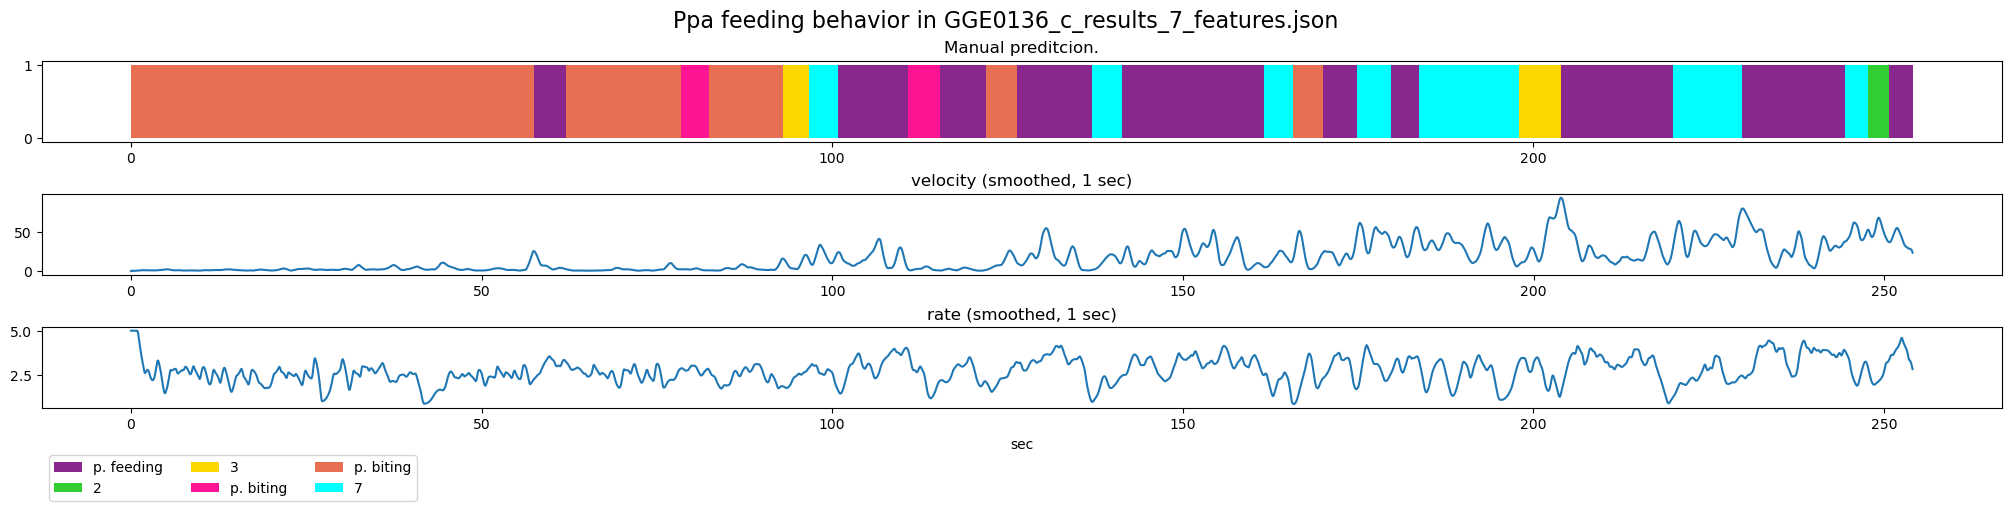

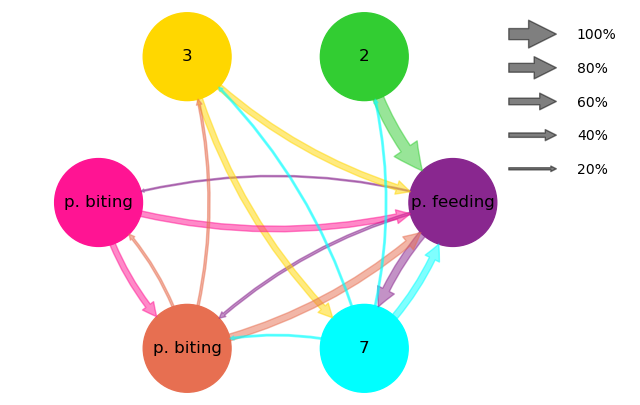

In [17]:
for y_ps, d, fn in zip(y_pred_smooth, data, in_engine):
    out_generic, out_specific = os.path.split(os.path.split(in_engine[fn])[0])
    out_specific = "_".join([out_specific.split("_")[0], 'predicted'])
    out = makedir(os.path.join(out_generic, out_specific))
    fn = os.path.basename(in_engine[fn])
    out_fn = '_'.join(fn.split('_')[:4]+['predicted.json'])
    p_out = pd.concat([d, pd.DataFrame(y_ps, columns=['prediction'])], axis=1)
    jsnL = json.loads(p_out.to_json(orient="split"))
    jsnF = json.dumps(jsnL, indent = 4)
    with open(os.path.join(out,out_fn), "w") as outfile:
        outfile.write(jsnF)
        
    
    onoff = proc.onoff_dict(y_ps, labels =np.unique(y_ps))
    timeinsec = np.array(range(len(d)))/30
    fig, axs = plt.subplots(3,1, figsize=(20,5),constrained_layout=True)

    for c in np.unique(y_ps).astype(int):
        axs[0].broken_barh(onoff[c],(0,1),facecolors = grouped_col[c])
    axs[0].set_xticks(range(len(timeinsec))[::100*30])
    axs[0].set_xticklabels(timeinsec[::100*30].astype(int))
    axs[0].set_title('Manual preditcion.')
    for i,c in enumerate(['velocity', 'rate']):
        axs[i+1].plot(timeinsec,d[c].rolling(30, min_periods=0).mean())
        axs[i+1].set_title(f"{c} (smoothed, 1 sec)")
    axs[2].set_xlabel('sec')

    plt.legend(handles=[Patch(facecolor=grouped_col[i]) for i in np.unique(y_ps).astype(int)],
          labels=[numtoname[k] for k in numtoname if k in np.unique(y_ps)],
          ncol=3, loc='upper left',
          bbox_to_anchor=(0, -0.5))
    fig.suptitle(f'Ppa feeding behavior in {fn}',fontsize=16)
    plt.savefig(os.path.join(out, '_'.join(fn.split('_')[:4]+['predictedbouts.pdf'])))
    plt.show()

    idx = pd.IndexSlice
    onoff, dur, transi = proc.onoff_dict(y_ps, labels =np.unique(y_ps), return_duration=True, return_transitions=True)
    data_describe = d.groupby(y_ps).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    dur_describe = pd.DataFrame(dur, columns=['duration']).groupby(transi).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    summary = pd.concat([dur_describe, data_describe], axis=1)
    summary.index.name = 'cluster'
    summary = summary.T.reset_index(drop=True).set_index(summary.T.index.map('_'.join)).T
    summary = summary.set_index(summary.index.astype(int))
    summary.to_csv(os.path.join(out, '_'.join(fn.split('_')[:4]+['summary.csv'])), index=False)

    frame = y_ps

    trans_col,fr_transition = crosstab(frame[1:], frame[:-1])
    othersum_axis0 = fr_transition.sum(axis=0)-fr_transition.diagonal()
    transition_toother = fr_transition/othersum_axis0
    transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())
    np.fill_diagonal(transition_toother, 0)

    transition_all = transition_toother.copy()
    diag_idx = np.diag_indices(len(transition_toother))
    transition_all[diag_idx] = transition_self
    transition_all = pd.DataFrame(transition_all, columns = trans_col[1], index=trans_col[0])
    transition_all.to_csv(os.path.join(out, '_'.join(fn.split('_')[:4]+['transitions.csv'])), index=False)

    A = np.around(transition_toother,2).T
    labels = dict(zip(range(len(trans_col[0])),trans_col[0]))
    G = nx.from_numpy_matrix(transition_toother.T, create_using=nx.DiGraph)

    # Set node labels to A, B, C, D, E
    #nx.set_node_attributes(G, {k: {'label': numtoname[k]} for k in numtoname.keys()})
    #nx.set_edge_attributes(G, {(e[0], e[1]): {'label': e[2]['weight']} for e in G.edges(data=True)})
    weights = nx.get_edge_attributes(G,'weight').values()
    arr_out = [e[0] for e in G.edges(data=True)]

    fig, ax = plt.subplots(1, figsize=(8,5))

    fig_w = fig.get_size_inches()[0]
    arrowsize = [w*fig_w*5 for w in weights]
    labels = dict(zip(range(len(G)),  [numtoname[k] for k in np.unique(y_ps)]))
    label_collection = nx.draw_networkx_labels(G, pos=nx.circular_layout(G), ax=ax, labels=labels)
    color_map = []
    for c in np.unique(y_ps):
        color_map.append(grouped_col[c])
    edge_color = [grouped_col[np.unique(y_ps)[c]] for c in arr_out]
    node_collection = nx.draw_networkx_nodes(G, pos=nx.circular_layout(G), ax=ax, node_color = color_map, node_size= 4000, margins=0.1)
    edge_collection = nx.draw_networkx_edges(G, pos=nx.circular_layout(G), ax=ax, 
                                             arrowsize =arrowsize, connectionstyle="arc3,rad=0.15", arrowstyle="simple",
                                             alpha=0.5, label=list(weights), node_size=4000, edge_color=edge_color)
    for ed in edge_collection:
        ed.set_zorder(20)
    #edge_label_col =  nx. draw_networkx_edge_labels(G, pos=nx.circular_layout(G), ax=ax, edge_labels= {(e[0], e[1]):e[2]['weight'] for e in G.edges(data=True)}, label_pos=0.4)

    #fig, ax = plt.subplots(1, figsize=(7,5))
    for arr_s in np.linspace(0.2,1,5):
        arrow = FancyArrowPatch((1.3, arr_s), (1.6, arr_s), mutation_scale=arr_s*fig_w*5, label = arr_s, color='k', alpha=0.5)
        ax.text(1.7, arr_s-0.03, f"{int(arr_s*100)}%")
        ax.add_patch(arrow)
    ax.set_xlim(-1.5,2)
    ax.axis('off')
    plt.savefig(os.path.join(out, '_'.join(fn.split('_')[:4]+['transitions.pdf'])))
    plt.show()